<a href="https://colab.research.google.com/github/geeorgebixleer/Esencia-del-cliente-Alura-Challenge/blob/main/robot_trading_BTC_USD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alura Challenge: Robot trading BTC-USD**

Robot Trading BTC-USD es un algoritmo de decisión simple automatizado capaz de tomar decisiones de compra y venta de Bitcoin en tiempo real y está desarrollado en el entorno virtual Google Colaboratory.

El resultado de este código será un gráfico mostrando un periodo de los ultimos 7 días del precio BTC-USD y la decisión del algoritmo en tiempo real, basado en datos normalizados y limpios, que se actualizarán cada 5 minutos.
Librerias utilizadas:

Pandas
Numpy
Matplotlib
yfinance
BeautifulSoup
time


#1.Configurando el ambiente

In [14]:
# importando librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from bs4 import BeautifulSoup
import requests
from IPython.display import clear_output
import time

In [15]:
# verificacion de versiones
!python -V
print('-----')
!pip show Pandas
print('-----')
!pip show Numpy
print('-----')
!pip show Matplotlib

Python 3.10.12
-----
Name: pandas
Version: 1.5.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: The Pandas Development Team
Author-email: pandas-dev@python.org
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, python-dateutil, pytz
Required-by: altair, arviz, bigframes, bokeh, bqplot, cmdstanpy, cufflinks, datascience, db-dtypes, dopamine-rl, fastai, geemap, geopandas, google-colab, gspread-dataframe, holoviews, ibis-framework, mizani, mlxtend, pandas-datareader, pandas-gbq, panel, pins, plotnine, prophet, pymc, seaborn, sklearn-pandas, statsmodels, vega-datasets, xarray, yfinance
-----
Name: numpy
Version: 1.25.2
Summary: Fundamental package for array computing in Python
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD-3-Clause
Location: /usr/local/lib/python3.10/dist-packages
Requires: 
Required-by: albumentations, altair,

In [16]:
# variables globales
global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision

#2.Obtención de Datos

##2.1. Histórico BTC-USD
Función que extrae los históricos de bitcoin (*BTC-USD*) para un periodo de 7 días con intervalos 5min. Los datos son tomados de Yahoo Finance (*yf.Ticker*)


In [17]:
def importar_base_bitcoin():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin = yf.Ticker("BTC-USD"). history(period='7d', interval='5m') # extracción precio ultimos 7 días
  df_bitcoin = pd.DataFrame(df_bitcoin) # transformando a dataframe
  return df_bitcoin
importar_base_bitcoin()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Datetime,,,,,,,
2024-03-01 00:00:00+00:00,61168.062500,61212.707031,61168.062500,61186.808594,0,0.0,0.0
2024-03-01 00:05:00+00:00,61167.128906,61340.234375,61167.128906,61340.234375,0,0.0,0.0
2024-03-01 00:10:00+00:00,61329.671875,61340.468750,61279.171875,61279.171875,0,0.0,0.0
2024-03-01 00:15:00+00:00,61263.343750,61462.906250,61227.261719,61453.394531,0,0.0,0.0
2024-03-01 00:20:00+00:00,61475.863281,61486.406250,61447.632812,61447.632812,0,0.0,0.0
...,...,...,...,...,...,...,...
2024-03-07 19:15:00+00:00,67778.835938,67778.835938,67602.171875,67627.492188,3887104,0.0,0.0
2024-03-07 19:20:00+00:00,67609.484375,67609.484375,67401.757812,67401.757812,1495040,0.0,0.0
2024-03-07 19:25:00+00:00,67416.125000,67436.945312,67402.343750,67406.226562,3715072,0.0,0.0


##2.2. Precio actual-tendencia BTC-USD
Función que usa webscrapping (*BeautifulSoup*) para extraer el precio actual (*'precio_actual'*) y tendencias de alta o baja (*'tendencia'*) de BTC-USD.

In [18]:
def extraer_tendencias():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  headers = {'User-Agent' : 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/118.0.0.0 Safari/537.36'}
  url = 'https://coinmarketcap.com/'
  respuesta = requests.get(url, headers = headers) # conexión a página coinmarketcap
  s = BeautifulSoup(respuesta.content, features = 'lxml')

  criptomonedas = s.findAll('p', {'class':'sc-4984dd93-0 iqdbQL coin-item-symbol'}) # extraccion de criptomonedas
  indice = 0
  for item in criptomonedas: # ciclo que selecciona BTC entre las criptomonedas
    if item.getText()=='BTC':
     break
    indice+=1

  precios = s.findAll('div', {'class': ['sc-500f568e-0 ejtlWy', 'sc-500f568e-0 ejtlWy fall', 'sc-500f568e-0 ejtlWy rise']}) # extraccion de clases del precio
  precio_actual = float(precios[indice].getText().replace('$', '').replace(',','')) # conversión de precio a float y limpieza de caracteres

  lista = []
  respuesta = s.findAll('span', {'class': ['sc-6a54057-0 iEhQde', 'sc-6a54057-0 YXxPZ']}) # extracción de tendencias alta y baja
  for item in respuesta[::3]:
    lista.append(item)

  tendencia = '' # seleccion de tendencia baja o alta
  if lista[indice].find('span')['class'][0] == 'icon-Caret-down':
    tendencia = 'baja'
  else:
    tendencia = 'alta'
extraer_tendencias()

#3.Limpieza de Datos
La siguiente función y fragmenos de código permiten realizar gráficos de caja donde es posible visualizar y excluir los outliers respecto a precio de cierre (*'Close'*).

In [19]:
def limpieza_datos():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin_limpio = pd.DataFrame(df_bitcoin) # dataframe para limpieza y tratamiento
  df_bitcoin_limpio.dropna(subset = ['Close'], inplace = True) # eliminando valores nulos columna 'Close'
  volume0 = df_bitcoin_limpio['Volume'] > 0 # filtro valores >0
  df_bitcoin_limpio = df_bitcoin_limpio[volume0] #aplicando filtro en dataframe
limpieza_datos()

##3.4. Outliers ['Close']

<Axes: >

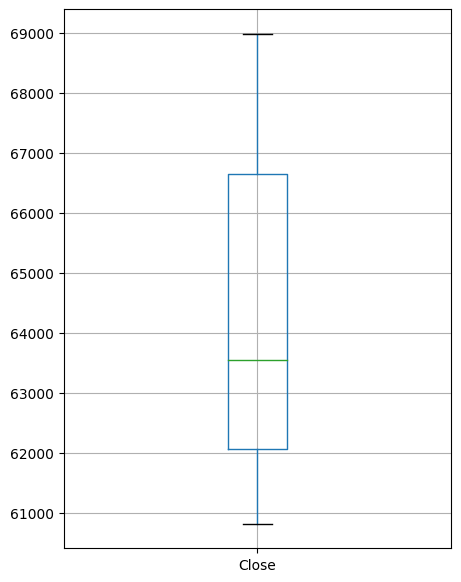

In [20]:
df_bitcoin.boxplot(['Close'], figsize = (5,7))

In [21]:
close = df_bitcoin_limpio['Close']
Q1 = close.quantile(.25) # quartil 1
Q3 = close.quantile(.75) # quartil 3
IIQ = Q3-Q1 # intervalo interquartil
limite_inferior = Q1 - 1.5 * IIQ
limite_superior = Q3 + 1.5 * IIQ
outliers_close = ((close >= limite_inferior) & (close <= limite_superior)) # filtro de seleccion de registros cuyo precio se encuentra entre Q1 y Q3
df_bitcoin_limpio = df_bitcoin_limpio[outliers_close] # aplicando filtro
media_bitcoin = df_bitcoin_limpio['Close'].mean() # obteniendo precio promedio

<Axes: >

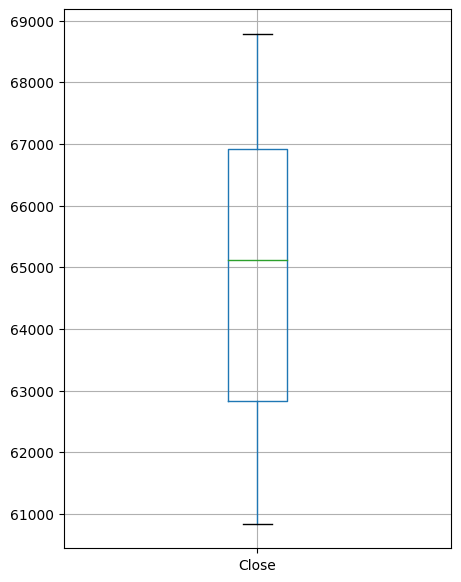

In [22]:
df_bitcoin_limpio.boxplot(['Close'], figsize = (5,7))

#4.Tomar Decisiones
Función que analiza el precio actual de BTC-USD y determina la acción a realizar: 'comprar', 'vender' o 'esperar'.

In [23]:
def tomar_decisiones(): # algoritmo de toma de decisiones
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  if precio_actual >= media_bitcoin and tendencia == 'baja':
    algoritmo_decision = 'Vender'
  elif precio_actual < media_bitcoin and tendencia == 'alta':
    algoritmo_decision = ' Comprar'
  else:
    algoritmo_decision = 'Espera'
  return algoritmo_decision
tomar_decisiones()

'Vender'

#5.Visualización
La siguiente función realiza un gráfico de lineas, para lo cuál, toma  como valores el precio de cierre (*'Close'*) y el precio promedio (*'Promedio'*). En el gráfico aparece una anotación con la acción a realizar de acuerdo el precio actual y la tendencia del mercado.

In [24]:
def visualizacion():
  global df_bitcoin, df_bitcoin_limpio, precio_actual, tendencia, media_bitcoin,  algoritmo_decision
  df_bitcoin['Promedio'] = media_bitcoin # nueva columna con precio promedio dataframe original
  fig = plt.figure(figsize=(16,5)) # generando tamaño de figura del gráfico
  eje = fig.add_axes([0,0,1,1]) # delimitando ejes de la figura
  eje.grid(True) # añadiendo cuadrícula

  eje.plot(df_bitcoin.index, df_bitcoin['Close'], color = 'g') # ejecutando gráfico con valores de fecha y precio de cierre
  eje.plot(df_bitcoin.index, df_bitcoin['Promedio'], color='r', linestyle='--') # ejecutando linea de precio promedio

  eje.set_title('Tendencia en tiempo real BTC-USD', fontsize=25, pad=20) # titulo
  eje.set_xlabel('Fecha', fontsize=20) # etiqueta eje x
  eje.set_ylabel('BTC-USD', fontsize=20) # etiqueta eje y

# impresión de texto con la decición de compra, venta o espera
  eje.annotate('{}'.format(algoritmo_decision), xy=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), xytext=(df_bitcoin.index[-1], df_bitcoin['Close'].iloc[-1]), fontsize=15, color='r')

# impresión de valores: precio actual, precio promedio y tendencia
  print('Precio actual BTC-USD: {} \nPrecio promedio BTC-USD: {} \nTendencia BTC-USD: {}'.format(precio_actual, media_bitcoin.round(3), tendencia))
  plt.show() # ejecución de gráfico

#6.Automatización
A continuación se ejecutan las funciones creadas anteriormente, obteniendo como resultado un gráfico que muestra los ultimos 7 días del precio BTC-USD y la decisión del algoritmo en tiempo real que se actualizarán cada 5 minutos.

Precio actual BTC-USD: 67649.2 
Precio promedio BTC-USD: 64904.439 
Tendencia BTC-USD: baja


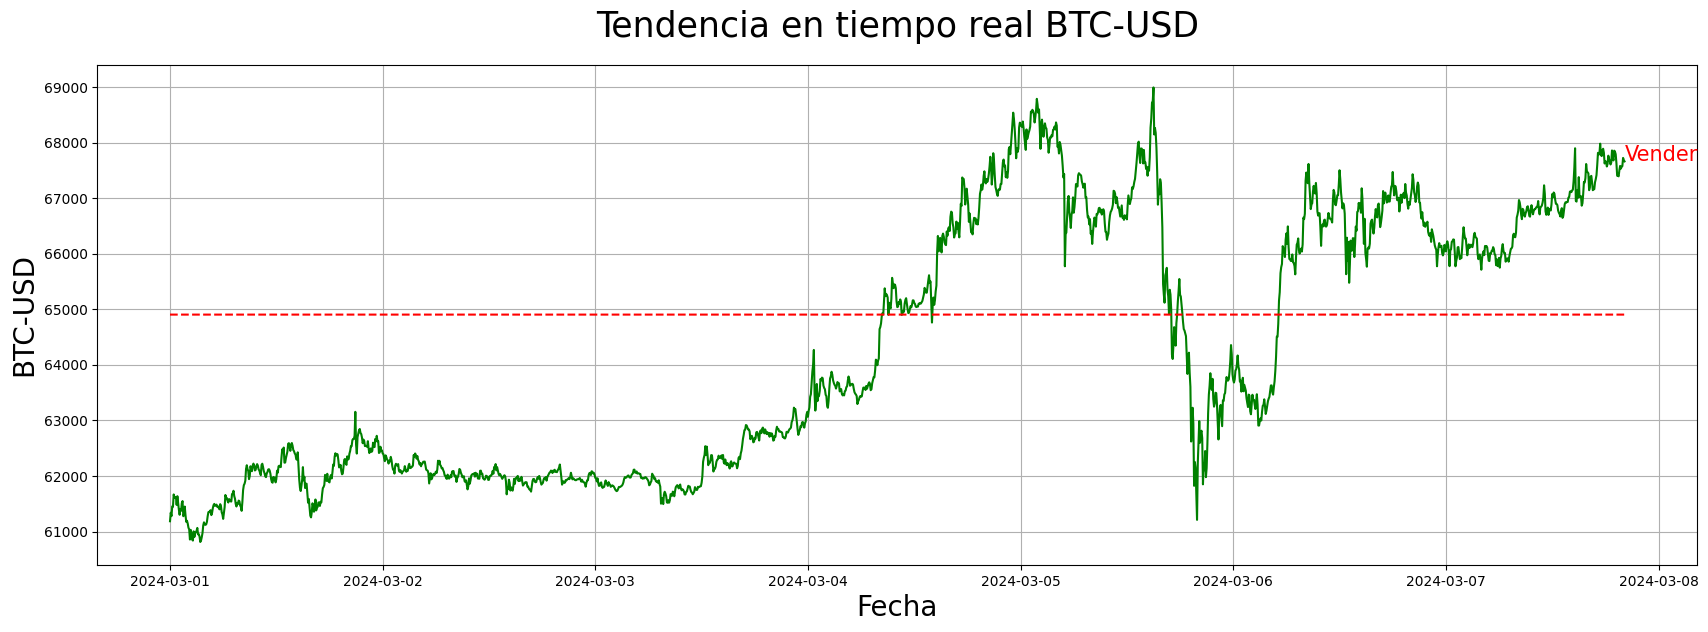

In [ ]:
while(True):
  clear_output() # limpia figura antes de plasmar gráfico
  importar_base_bitcoin() # extracción de datos BTC-USD
  extraer_tendencias() # extracción de precio y tendencia
  limpieza_datos() # limpieza de datos
  tomar_decisiones() # algoritmo de decsiones
  visualizacion() # gráfico de BTC-USD
  time.sleep(300) # actualiación de gráfico cada 5 minutos